In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.utils import clean_dataset

In [2]:
# file_path = '../../output/circum/2025-02-08_noAct_circum.parquet'
file_path = '../../output/circum/2024-01-24_SF_circum.parquet'

df = pd.read_parquet(file_path)

In [3]:
import re
match = re.search(r'(\d{4}-\d{2}-\d{2})_([^_]+)', file_path)
if match:
    extract_date, extract_type = match.groups()
    print("Date:", extract_date)
    print("Type:", extract_type)

Date: 2024-01-24
Type: SF


In [4]:
intersection_file = '../../helpers/intersection'

with open(intersection_file, "r") as file:
    intersection = file.read().splitlines()

In [5]:
df = clean_dataset(df, intersection)

In [6]:
categories_df = pd.read_csv('../../helpers/categories.csv', sep=',')
categories_df = categories_df[['init_host', 'Categories']]

In [7]:
cat_circum = df[(df.ref_flag != "Safe")
         | (df.post_flag != "Safe")
         | (df.url_flag != "Safe")]\
            .drop_duplicates('final_host')\
                .merge(categories_df, left_on='final_host', right_on='init_host' ,how='left')

In [8]:
df_value = cat_circum.Categories.value_counts().reset_index()


In [9]:
df_value['Categories'] = df_value['Categories'].str.replace('- ', '', regex=False)
df_value['Categories'] = df_value['Categories'].str.replace('-', ' ', regex=False)

In [10]:
cat_count_default = pd.read_csv('../../helpers/categories_count.csv', sep=',')

In [11]:
df_value = df_value.merge(cat_count_default, left_on='Categories', right_on='Categories', how='left')

In [12]:
df_value['percentage'] = df_value['count'] / df_value['cat_count'] * 100

In [13]:
filtered_df = df_value[df_value.cat_count > 100]

In [14]:
filtered_df.sort_values(by='percentage', ascending=False, inplace=True)

/tmp/ipykernel_279143/225246358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by='percentage', ascending=False, inplace=True)


In [15]:
filtered_df.head(5)

,Categories,count,cat_count,Take?,percentage
10,Fashion/Beauty,645,744,True,86.693548
1,Shopping/Merchandizing,2896,3445,True,84.063861
9,General News,705,840,True,83.928571
20,Real Estate,277,334,True,82.934132
3,Blogs/Wikis,1393,1701,True,81.893004


In [16]:
filtered_df.tail(5)

,Categories,count,cat_count,Take?,percentage
37,Content Server,64,104,True,61.538462
26,PUPs,154,255,True,60.392157
7,Uncategorized,803,1350,True,59.481481
14,Pornography,487,864,True,56.365741
29,Gambling,119,213,True,55.868545


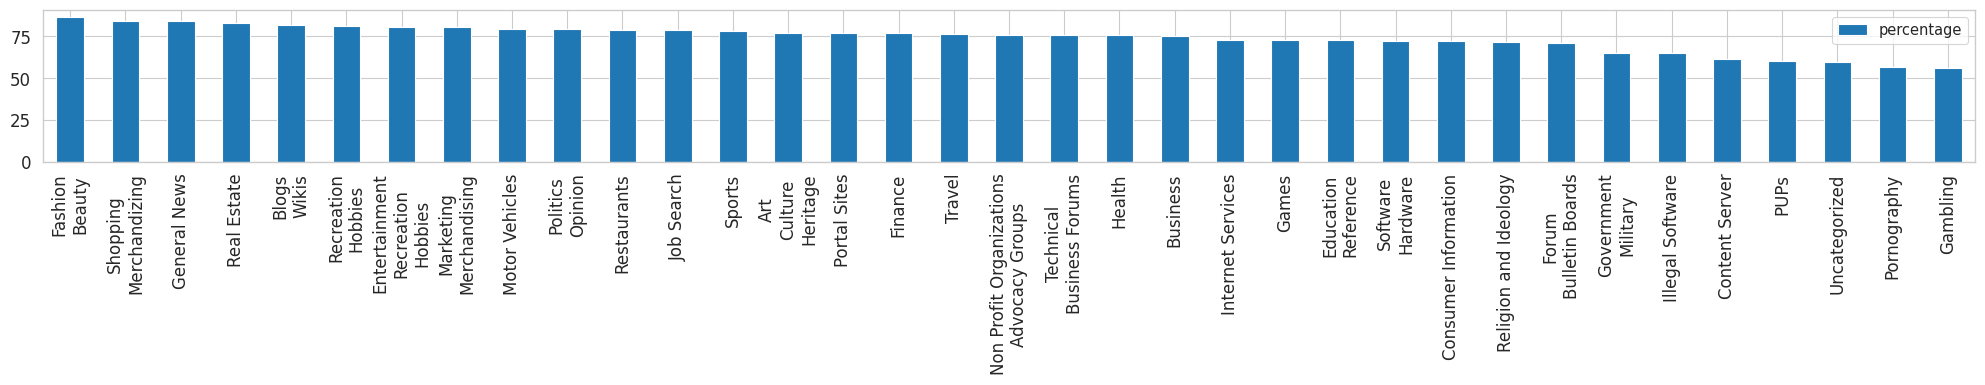

In [17]:
# Set the visual style and context with a slightly larger font scale
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)

# Create a figure and axes with a bit more height for clarity
fig, ax = plt.subplots(figsize=(20, 4))  # increased height from 2 to 4

# Plot the bar chart using Pandas plotting method
filtered_df.plot(kind='bar', x='Categories', y='percentage', ax=ax)

# Remove the default x-axis label (if it shows the column name)
ax.set_xlabel("")

# Improve x-tick labels:
# Split labels on '/' and adjust font size for better readability
labels = ['\n'.join(label.split('/')) for label in filtered_df['Categories']]
ax.set_xticklabels(labels, rotation=90, fontsize=18)

# Adjust tick parameters for both axes
ax.tick_params(axis='both', which='major', labelsize=12)

# Optionally add a y-axis label and a title for context
# ax.set_ylabel('Percentage', fontsize=12)
# ax.set_title('Percentage by Category', fontsize=14, pad=15)

# Ensure layout is adjusted to prevent overlapping elements
plt.tight_layout()

# Save the figure with a high DPI for publication-quality resolution
plt.savefig("../../output/chart/"+extract_type+'_cat.png', dpi=1200, bbox_inches='tight')

# Display the plot
plt.show()